<a href="https://colab.research.google.com/github/EddyGiusepe/Studying_spaCy_NER/blob/main/Train_Custom_NER_with_spaCy_v3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h2 align='center'>[Train Custom NER with Spacy v3.0](https://www.youtube.com/watch?v=9mXoGxAn6pM)</h2>


Data scientist.: Dr.Eddy Giusepe Chirinos Isidro

Este script está baseado no [vídeo do YouTube](https://www.youtube.com/watch?v=9mXoGxAn6pM), esté vídeo e script o guiará pelas etapas de treinamento de um ``NER personalizado`` para os requisitos de algum projeto similar. Você usará o poder de um modelo de transformador existente para transferir sua previsão personalizada em apenas $5$ etapas.

Este Notebook detalha as etapas para treinar a sua ``NER personalizado`` usando o novo formato do [spaCy](https://spacy.io/usage/training).

# <font color="green">[Pipelines e Modelos de Treinamento](https://spacy.io/usage/training)</font>


Treine e atualize componentes em seus próprios dados e integre modelos personalizados

O tagger, analisador (parser), categorizador de texto e muitos outros componentes do ``spaCy`` são alimentados por ``modelos estatísticos``. Cada “decisão” que esses componentes tomam – **por exemplo**, qual tag de parte da fala atribuir ou se uma palavra é uma entidade nomeada – é uma ``previsão`` baseada nos valores de peso atuais do modelo. Os valores de peso são estimados com base em exemplos que o modelo viu durante o treinamento . Para treinar um modelo, primeiro você precisa de dados de treinamento – exemplos de texto e os rótulos que você deseja que o modelo preveja. Isso pode ser uma tag de parte do discurso, uma entidade nomeada ou qualquer outra informação.

O treinamento é um processo iterativo no qual as previsões do modelo são comparadas com as anotações de referência para estimar o ``gradiente da perda``. O gradiente da perda é então usado para calcular o gradiente dos pesos através de [retropropagação](https://thinc.ai/docs/backprop101). Os gradientes indicam como os valores de peso devem ser alterados para que as previsões do modelo se tornem mais semelhantes aos rótulos de referência ao longo do tempo.

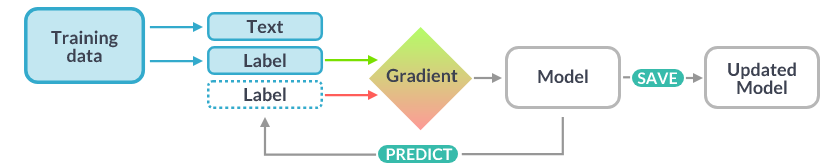

Ao treinar um modelo, não queremos apenas que ele memorize nossos exemplos – queremos que ele apresente uma teoria que possa ser ``generalizada em dados não vistos``. Afinal, não queremos apenas que o modelo aprenda que esta instância de “Amazon” aqui é uma empresa – queremos que ele aprenda que “Amazon”, em contextos como este, é provavelmente uma empresa. É por isso que os dados de treinamento devem sempre ser representativos dos dados que queremos processar. Um modelo treinado na Wikipedia, onde frases na primeira pessoa são extremamente raras, provavelmente terá um desempenho ruim no Twitter. Da mesma forma, um modelo treinado em romances românticos provavelmente terá um desempenho ruim no texto legal.

Isso também significa que, para saber o desempenho do modelo e se ele está aprendendo as coisas certas, você não precisa apenas de ``dados de treinamento``, mas também de ``dados de avaliação``. Se você testar o modelo apenas com os dados em que foi treinado, não terá ideia de quão bem ele está generalizando. Se você deseja treinar um modelo do zero, geralmente precisa de pelo menos algumas centenas de exemplos para treinamento e avaliação.

# Passo 1: Criação de Dados de treinamento

Anotamos nossos dados

In [1]:
# Lembrar: estamos usando a versão3.0
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 2.1 MB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 61.2 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.1/457.1 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.3/653.3 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: smart-open
    Found existing installation: smart-open 6.0.0
    Uninstalling smart-open-6.0.0:
      Successfully uninstalled smart-open-6.0.0
  Attempting uninstall: catalogue
    Found existing installation: catalo

In [2]:
TRAIN_DATA = [
 ('The F15 aircraft uses a lot of fuel', {'entities': [(4, 7, 'aircraft')]}),
 ('did you see the F16 landing?', {'entities': [(16, 19, 'aircraft')]}),
 ('how many missiles can a F35 carry', {'entities': [(24, 27, 'aircraft')]}),
 ('is the F15 outdated', {'entities': [(7, 10, 'aircraft')]}),
 ('does the US still train pilots to dog fight?', {'entities': [(0, 0, 'aircraft')]}),
 ('how long does it take to train a F16 pilot', {'entities': [(33, 36, 'aircraft')]}),
 ('how much does a F35 cost', {'entities': [(16, 19, 'aircraft')]}),
 ('would it be possible to steal a F15', {'entities': [(32, 35, 'aircraft')]}),
 ('who manufactures the F16', {'entities': [(21, 24, 'aircraft')]}),
 ('how many countries have bought the F35', {'entities': [(35, 38, 'aircraft')]}),
 ('is the F35 a waste of money', {'entities': [(7, 10, 'aircraft')]})
 ]

# Passo 2: Conversão de Dados para o formato spaCy

Copiamos os Dados de treinamento e o script abaixo e executamos a partir da ``linha de comando``.

In [3]:
# Importamos as bibliotecas necessárias

import pandas as pd
import os
from tqdm import tqdm
import spacy
from spacy.tokens import DocBin

In [4]:
# Link de erro: https://stackoverflow.com/questions/68330544/cant-able-to-convert-old-spacy-2-0-data-to-new-spacy-3-0-acceptable-format

#nlp = spacy.blank("en") # load a new spacy model
nlp = spacy.load("en_core_web_sm") # load other spacy model

db = DocBin() # create a DocBin object

for text, annot in tqdm(TRAIN_DATA): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents # label the text with the ents
    db.add(doc)

#os.chdir(r'/content/drive/MyDrive/3_EDDY_ISH_TECNOLOGIA/4_ML_inside_of _MANTIS/1_Tratando_Dados_json_Mantis/Applying_spaCy_to_Mantis')
db.to_disk("./train.spacy") # save the docbin object

100%|██████████| 11/11 [00:00<00:00, 3117.18it/s]

Skipping entity


# Passo 3: Criando o arquivo de configuração para treinar o modelo

https://spacy.io/usage/training#config

Vá para a seção Quickstart da página e selecione sua configuração. (Certifique-se de marcar ``NER``, você pode selecionar o idioma com base em sua exigência)

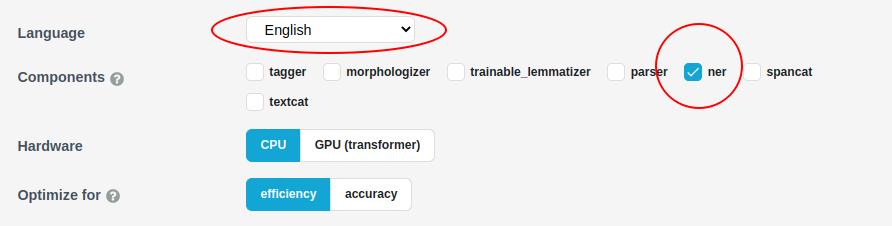

Uma vez que as configurações estão definidas, você pode baixá-lo.

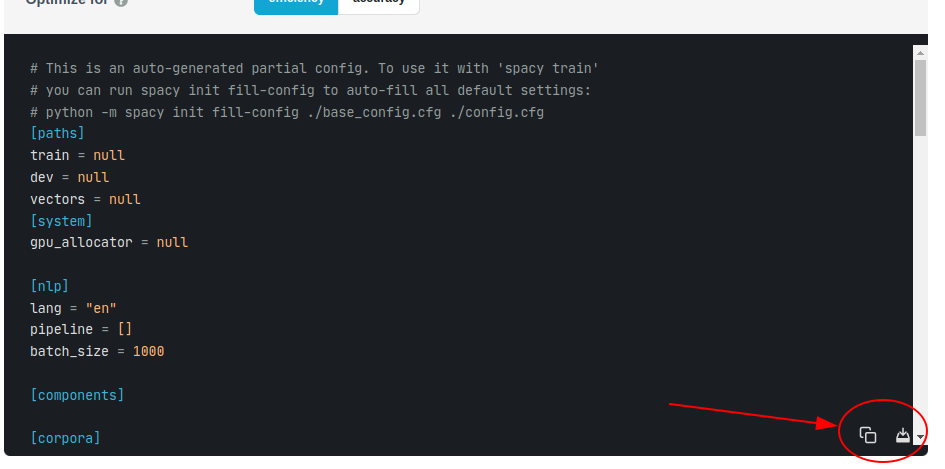

# Passo 4: Preenchendo o arquivo de configuração

Vá para o diretório onde o base_config.cfg está armazenado e execute este comando:

```
!python -m spacy init fill-config base_config.cfg config.cfg
```

In [6]:
# Ao executar o base_config.cfg --> vai gerar config.cfg

!python -m spacy init fill-config base_config.cfg config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


# Passo 5: Execute a configuração de treinamento

```
!python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./train.spacy 
```

<font color="yellow">Aqui coloco o print para poder observar os arquivos que foram gerados</font>

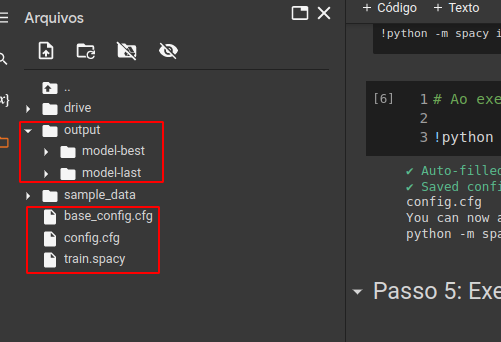

In [7]:
# Ao treinar geraremos dois modelos (o best e o last)

!python -m spacy train config.cfg --output ./output --paths.train ./train.spacy --paths.dev ./train.spacy 

✔ Created output directory: output
ℹ Saving to output directory: output
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
[2022-05-13 04:03:18,996] [INFO] Set up nlp object from config
[2022-05-13 04:03:19,005] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-05-13 04:03:19,009] [INFO] Created vocabulary
[2022-05-13 04:03:19,010] [INFO] Finished initializing nlp object
[2022-05-13 04:03:19,102] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     41.50    0.00    0.00    0.00    0.00
200     200          1.10    476.85  100.00  100.00  100.00    1.00
400     400          0.00  

In [9]:

nlp1 = spacy.load(r"/content/output/model-best") #load the best model

doc = nlp1("there was a flight named D16") # input sample text


In [10]:
spacy.displacy.render(doc, style="ent", jupyter=True) # display in Jupyter